In [17]:
import kagglehub
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from openpyxl.styles import Font
from openpyxl.drawing.image import Image

path = kagglehub.dataset_download("bejopamungkas/transaksi-pembelian-penjualan-sembako")

df_pemasukan_barang = pd.read_csv(os.path.join(path, "pemasukan barang.csv"))
df_penjualan_barang = pd.read_csv(os.path.join(path, "penjualan barang.csv"))

### Reporting

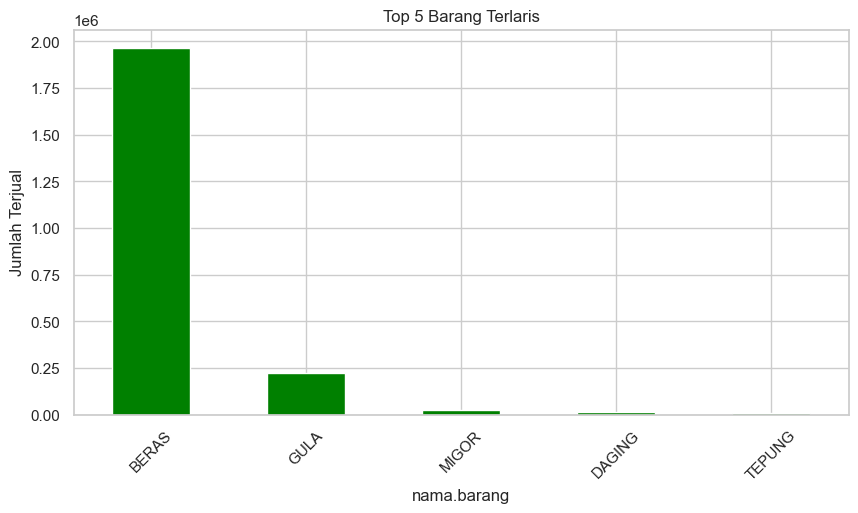

In [18]:
df_penjualan_barang["tanggal"] = pd.to_datetime(df_penjualan_barang["tanggal"])
df_penjualan_barang = df_penjualan_barang.sort_values("tanggal")
jml_barang_masuk = df_pemasukan_barang.groupby("nama.barang")["kuantum"].sum()
jml_barang_dijual = df_penjualan_barang.groupby("nama.barang")["kuantum"].sum()
sisa_stock = jml_barang_masuk - jml_barang_dijual

df_penjualan_barang["rata_rata_7hari"] = df_penjualan_barang.groupby("nama.barang")["kuantum"]\
    .rolling(7, min_periods=1).mean().reset_index(0, drop=True)

sisa_stock_df = pd.DataFrame({
    "Barang": sisa_stock.index,
    "Sisa Stok": sisa_stock.values,
    "Rata-rata Penjualan (7 Hari)": df_penjualan_barang.groupby("nama.barang")["rata_rata_7hari"].last().fillna(0)
})

sisa_stock_df["Estimasi Habis (hari)"] = sisa_stock_df["Sisa Stok"] / sisa_stock_df["Rata-rata Penjualan (7 Hari)"]
sisa_stock_df = sisa_stock_df.sort_values("Estimasi Habis (hari)", ascending=True)

laporan_stok = pd.DataFrame({
    "Barang": jml_barang_masuk.index,
    "Total Masuk": jml_barang_masuk.values,
    "Total Terjual": jml_barang_dijual.values,
    "Sisa Stok": sisa_stock.values
})

def format_rupiah(x):
    return f"Rp {x:,.0f}".replace(",", ".")

# Laporan Pembeli
pembeli = df_penjualan_barang.groupby('nama.pembeli')["nominal"].sum()
laporan_pembeli = pembeli.sort_values(ascending=False).head(10).apply(format_rupiah).reset_index()
laporan_pembeli.columns = ["Nama Pembeli", "Total Pembelian"]

# Laporan Penjualan Harian
laporan_penjualan_harian = df_penjualan_barang.groupby("tanggal")[["nominal", "kuantum"]].sum().reset_index()

# Barang Terlaris & Tidak Laku
barang_terlaris = df_penjualan_barang.groupby("nama.barang")["kuantum"].sum().sort_values(ascending=False)
top5_barang = barang_terlaris.head(5)
bottom5_barang = barang_terlaris.tail(5)

# Barang Hampir Habis (Threshold < 10)
threshold = 10
barang_hampir_habis = laporan_stok[laporan_stok["Sisa Stok"] < threshold]

# Menyimpan Semua Data ke Excel
file_excel = "Laporan_Sembako.xlsx"
with pd.ExcelWriter(file_excel, engine="openpyxl") as writer:
    laporan_stok.to_excel(writer, sheet_name="Stok Barang", index=False)
    laporan_pembeli.to_excel(writer, sheet_name="Top 10 Pembeli", index=False)
    laporan_penjualan_harian.to_excel(writer, sheet_name="Penjualan Harian", index=False)
    top5_barang.to_excel(writer, sheet_name="Barang Terlaris")
    bottom5_barang.to_excel(writer, sheet_name="Barang Tidak Laku")
    barang_hampir_habis.to_excel(writer, sheet_name="Barang Hampir Habis", index=False)
    sisa_stock_df.to_excel(writer, sheet_name="Prediksi Stok", index=False)

# Menambahkan Format Judul ke Setiap Sheet
wb = load_workbook(file_excel)
for sheet in wb.sheetnames:
    ws = wb[sheet]
    ws["A1"].font = Font(bold=True, color="0000FF") 

wb.save(file_excel)

# Buat Grafik Barang Terlaris
plt.figure(figsize=(10, 5))
top5_barang.plot(kind="bar", color="green")
plt.title("Top 5 Barang Terlaris")
plt.ylabel("Jumlah Terjual")
plt.xticks(rotation=45)
plt.savefig("grafik_barang_terlaris.png")  

# Masukkan Gambar ke Excel
ws = wb.create_sheet("Grafik Penjualan")
img = Image("grafik_barang_terlaris.png")
ws.add_image(img, "A1")  

wb.save(file_excel)

### Ploting

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plotting(value1, value2):
    sns.set(style="whitegrid")

    if value2.lower() == 'barang':
        data_pemasukan = df_pemasukan_barang.groupby(['tanggal', 'nama.barang'], as_index=False).sum()
        data_penjualan = df_penjualan_barang.groupby(['tanggal', 'nama.barang'], as_index=False).sum()
        data_pemasukan['tanggal'] = pd.to_datetime(data_pemasukan['tanggal'])
        data_penjualan['tanggal'] = pd.to_datetime(data_penjualan['tanggal'])

        value1_upper = value1.upper()
        data_pemasukan_filtered = data_pemasukan[data_pemasukan['nama.barang'].str.upper() == value1_upper]
        data_penjualan_filtered = data_penjualan[data_penjualan['nama.barang'].str.upper() == value1_upper]

        if data_pemasukan_filtered.empty and data_penjualan_filtered.empty:
            print(f"Tidak ada data untuk barang '{value1}'!")
            return

        plt.figure(figsize=(12, 7))
        plt.plot(data_pemasukan_filtered['tanggal'], data_pemasukan_filtered['kuantum'],
                 linestyle='-', linewidth=2, markersize=8, color="blue", label='Pemasukan')

        plt.plot(data_penjualan_filtered['tanggal'], data_penjualan_filtered['kuantum'],
                 linestyle='--', linewidth=2, markersize=8, color="red", label='Penjualan')

        plt.xlabel('Tanggal', fontsize=14)
        plt.ylabel('Kuantum', fontsize=14)
        plt.title(f"Tren Kuantum Barang {value1_upper} (Pemasukan vs Penjualan)", fontsize=16)
        plt.xticks(rotation=45)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    elif value2.lower() == 'pembeli':
        data_penjualan = df_penjualan_barang.groupby(['tanggal', 'nama.pembeli'], as_index=False).sum()
        data_penjualan['tanggal'] = pd.to_datetime(data_penjualan['tanggal'])
        value1_upper = value1.upper()
        data_penjualan_filtered = data_penjualan[data_penjualan['nama.pembeli'].str.upper() == value1_upper]

        if data_penjualan_filtered.empty:
            print(f"Tidak ada data untuk pembeli '{value1}'!")
            return

        plt.figure(figsize=(10, 5))
        sns.lineplot(x=data_penjualan_filtered['tanggal'], 
                     y=data_penjualan_filtered['nominal'] / 1_000_000,  
                     marker='o', linewidth=2, color="green", label="Penjualan")

        plt.xlabel('Tanggal', fontsize=12)
        plt.ylabel('Nominal (Juta Rupiah)', fontsize=12)
        plt.title(f"Tren Penjualan {value1_upper} dari Waktu ke Waktu", fontsize=14)
        plt.xticks(rotation=45)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    else:
        print("Pilihan tidak valid! Gunakan 'barang' atau 'pembeli'.")


C:\Users\51206614\AppData\Local\Temp\ipykernel_11412\375678400.py:42: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\51206614\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


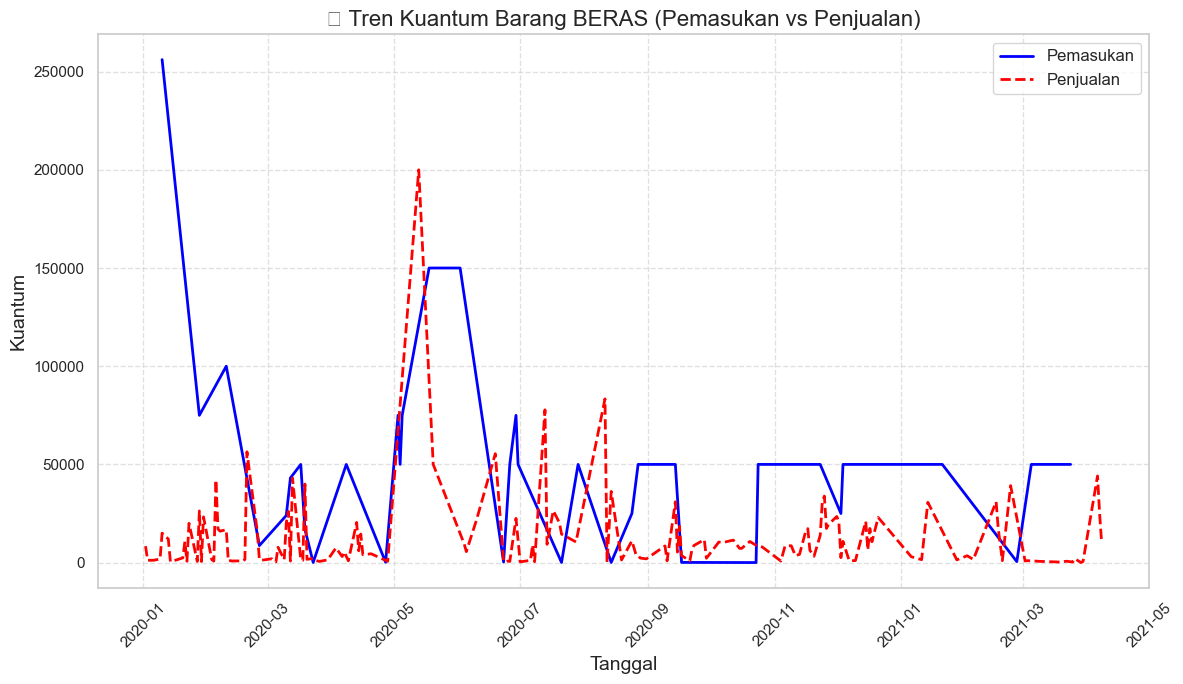

In [15]:
plotting('beras','barang')